In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import pandas as pd
import numpy as np

In [7]:
df_raw = pd.read_csv('./developer_survey_2019/survey_results_public.csv', low_memory=False)
schema = pd.read_csv('./developer_survey_2019/survey_results_schema.csv')

In [8]:
df_raw.JobSat.unique()

array([nan, 'Slightly satisfied', 'Slightly dissatisfied',
       'Neither satisfied nor dissatisfied', 'Very satisfied',
       'Very dissatisfied'], dtype=object)

In [9]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import lightgbm as lgm
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import scipy
from scipy.cluster import hierarchy as hc

In [10]:
# used functionality 

def mad(x,y): return sum(abs(x-y))/len(x)

def handle_multi_string_columns(df, column, single_strings):
    '''
    Replaces column whose fields contain several strings with new columns. Each
    new column will then represent a single string
    
    INPUT:
    df - the pandas dataframe you want to search
    column - the column name you want to look through
    single_strings - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - The dataframe without the multi-string column but with the newly created columns
    col_dict - Dictionary translating names of the new columns to their corresponding string
    '''
    
    #collects new columns of indicating if a certain index refers to a string 
    new_columns = dict()
    
    #dict column name -> string name
    col_dict = dict()
    
    #loop through list of strings
    counter = 0
    for string in single_strings:
        bool_list = []
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row set to True
            if string in str(df[column][idx]):
                bool_list.append(1)
            else:
                bool_list.append(0)
        col_name = column + "_" + str(counter)
        new_columns[col_name] = bool_list
        col_dict[col_name] = string
        counter = counter + 1
    
    new_df = df.drop(column,axis=1)
    
    new_df = pd.concat([new_df, pd.DataFrame(data=new_columns, index = df.index, dtype=int)], axis=1)
    
    return new_df, col_dict


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def mean_absolute_error_2(y_true, y_pred):
    return mean_absolute_error(y_true, np.round(y_pred))


def classification(y_train, y_test_preds):
    y_train_min = np.min(y_train)
    y_train_max = np.max(y_train)
    total_distance = y_train_max - y_train_min
    point_0 = y_train_min + total_distance * np.sum(y_train == 0) / len(y_train)
    point_1 = point_0 + total_distance * np.sum(y_train == 1) / len(y_train)
    point_2 = point_1 + total_distance * np.sum(y_train == 2) / len(y_train)
    point_3 = point_2 + total_distance * np.sum(y_train == 3) / len(y_train)
    point_4 = y_train_max
    
    for i in range(len(y_test_preds)):
        if y_test_preds[i] <= point_0:
            y_test_preds[i] = 0
        elif y_test_preds[i] <= point_1:
            y_test_preds[i] = 1
        elif y_test_preds[i] <= point_2:
            y_test_preds[i] = 2
        elif y_test_preds[i] <= point_3:
            y_test_preds[i] = 3
        elif y_test_preds[i] <= point_4:
            y_test_preds[i] = 4
        else:
            print("An error occurred!")
            break
    
        return y_test_preds

In [11]:
df = df_raw.dropna(subset=['JobSat'], axis=0)
df = df[df.Employment.isin(['Employed full-time', 'Employed part-time'])]
df = df[df.Student == 'No']
df = df.drop(['Respondent','ResumeUpdate','CurrencySymbol','CurrencyDesc','CompTotal','SurveyEase','SurveyLength','SONewContent','WelcomeChange','SOComm','EntTeams','SOVisit1st',
                 'SOVisitFreq', 'SOVisitTo', 'SOFindAnswer', 'SOTimeSaved', 'SOHowMuchTime', 'SOAccount','SOPartFreq', 'SOJobs', 'LanguageWorkedWith', 'LanguageDesireNextYear',
                 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith', 'PlatformDesireNextYear', 'WebFrameWorkedWith', 'WebFrameDesireNextYear', 'MiscTechWorkedWith', 
                 'MiscTechDesireNextYear', 'DevEnviron','Student','Ethnicity','JobSeek', 'MgrIdiot'], axis=1)
df = df.dropna(thresh=45)
df = df.reset_index(drop=True)

In [12]:
EduOther_strings = ['Taken an online course in programming or software development (e.g. a MOOC)','Participated in a fulltime developer training program or bootcamp',
                    'Taken a part-time in-person course in programming or software development','Completed an industry certification program (e.g. MCPD)',
                    'Received on-the-job training in software development','Taught yourself a new language, framework, or tool without taking a formal course',
                    'Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)','Participated in a hackathon','Contributed to open source software',
                    'None of these']

DevType_strings = ['Academic researcher','Data or business analyst','Data scientist or machine learning specialist','Database administrator','Designer','Developer, back-end',
                   'Developer, desktop or enterprise applications','Developer, embedded applications or devices','Developer, front-end','Developer, full-stack',
                   'Developer, game or graphics','Developer, mobile','Developer, QA or test','DevOps specialist','Educator','Engineer, data','Engineer, site reliability',
                   'Engineering manager','Marketing or sales professional','Product manager','Scientist',"Senior Executive (C-Suite, VP, etc.)", 'Student', 'System administrator']

LastInt_strings = ['Write any code','Write code by hand (e.g., on a whiteboard)','Complete a take-home project','Solve a brain-teaser style puzzle','Interview with people in peer roles',
                   'Interview with people in senior / management roles']

WorkChallenge_strings = ['Distracting work environment','Being tasked with non-development work','Meetings','Time spent commuting','Not enough people for the workload',
                         'Toxic work environment','Inadequate access to necessary tools','Lack of support from management','Non-work commitments (parenting, school work, hobbies, etc.)']

JobFactors_strings = ['Diversity of the company or organization',"Languages, frameworks, and other technologies I'd be working with","Industry that I'd be working in",
                      'How widely used or impactful my work output would be',"Specific department or team I'd be working on",'Flex time or a flexible schedule',
                      'Remote work options','Financial performance or funding status of the company or organization','Office environment or company culture',
                      'Opportunities for professional development']

df, dict_EduOther = handle_multi_string_columns(df,"EduOther",EduOther_strings)
df, dict_DevType = handle_multi_string_columns(df,"DevType",DevType_strings)
df, dict_LastInt = handle_multi_string_columns(df,"LastInt",LastInt_strings)
df, dict_WorkChallenge = handle_multi_string_columns(df,"WorkChallenge",WorkChallenge_strings)
df, dict_JobFactors = handle_multi_string_columns(df,"JobFactors",JobFactors_strings)

In [13]:
dict_JobFactors

{'JobFactors_0': 'Diversity of the company or organization',
 'JobFactors_1': "Languages, frameworks, and other technologies I'd be working with",
 'JobFactors_2': "Industry that I'd be working in",
 'JobFactors_3': 'How widely used or impactful my work output would be',
 'JobFactors_4': "Specific department or team I'd be working on",
 'JobFactors_5': 'Flex time or a flexible schedule',
 'JobFactors_6': 'Remote work options',
 'JobFactors_7': 'Financial performance or funding status of the company or organization',
 'JobFactors_8': 'Office environment or company culture',
 'JobFactors_9': 'Opportunities for professional development'}

In [14]:
df["WorkChallenge_count"] = (
    df.WorkChallenge_0+df.WorkChallenge_1+df.WorkChallenge_2+df.WorkChallenge_3
    +df.WorkChallenge_4+df.WorkChallenge_5+df.WorkChallenge_6+df.WorkChallenge_7+df.WorkChallenge_8
)

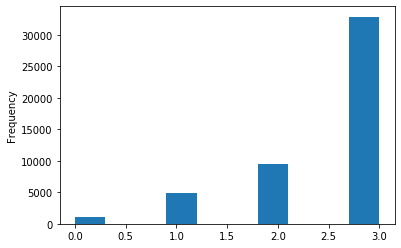

In [15]:
df.WorkChallenge_count.plot.hist()

In [16]:
# Converting the columns to categoricals
for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

df.JobSat.cat.set_categories(['Very dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied','Slightly satisfied', 'Very satisfied'], ordered=True, inplace=True)
df.CareerSat.cat.set_categories(['Very dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied','Slightly satisfied', 'Very satisfied'], ordered=True, inplace=True)
df.PurchaseHow.cat.set_categories(['The CTO, CIO, or other management purchase new technology typically without the involvement of developers','Not sure',
                                   'Developers and management have nearly equal input into purchasing new technology','Developers typically have the most influence on purchasing new technology'],
                                 ordered=True, inplace=True)

In [17]:
# Numerizing catecorical columns
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
df = df.apply(fill_mean, axis=0)

In [18]:
#Drop columns with all NaN values
df = df.dropna(how='all', axis=0)
df = df.dropna(how='all', axis=1)
#delete columns that add up to 0
df = df.loc[:, (df != 0).any(axis=0)]

In [51]:
# Produce a training, test and validation set
X = df.drop(['JobSat','CareerSat'] + [f"EduOther_{i}" for i in range(2,9)] + list(dict_JobFactors.keys()), axis=1)
y = df['JobSat']

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.4, random_state=14)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=14)

In [52]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [53]:
y_pred_test = linear_model.predict(X_test)

mad_test = mad(y_test, y_pred_test)

print("The MAD on test data with linear model is {:.5}".format(mad_test))

The MAD on test data with linear model is 0.964


In [54]:
param_grid = { 
    'n_estimators': np.arange(50, 300, 80),
    'max_depth': [4,6,8],
}

In [55]:
rfc = RandomForestClassifier(random_state=42)

In [56]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [58]:
CV_rfc.best_params_

{'max_depth': 8, 'n_estimators': 290}

In [59]:
rfc_final = RandomForestClassifier(n_estimators=CV_rfc.best_params_["n_estimators"], min_samples_split=2, random_state=42)

In [60]:
rfc_final.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=290,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [61]:
y_pred_test = rfc_final.predict(X_test)
y_pred_valid = rfc_final.predict(X_valid)

In [62]:
mad(y_test, y_pred_test) 

0.9351880473982483

In [63]:
mad(y_valid, y_pred_valid)

0.9506439979392066

(array([1.000e+00, 0.000e+00, 3.420e+02, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 5.771e+03, 0.000e+00, 3.589e+03]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

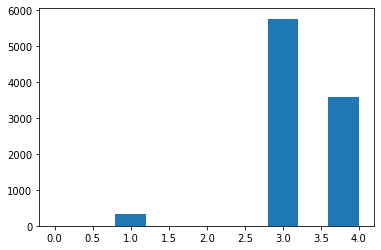

In [66]:
plt.hist(y_pred_test)

In [68]:
fi = rf_feat_importance(rfc_final, X)

* Feature engineering
* Model tuning
* Feature reduction (without loss of quality)
* Feature importance (also manual? "leave one out", "leave two out")


In [71]:
fi[fi.imp>0.01].shape

(37, 2)